In [1]:
# 20210802 
# sarahfong
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
import numpy as np
import os, sys

import pandas as pd
from scipy import stats
import seaborn as sns 
import statsmodels
import statsmodels.api as sm
import subprocess

/accre/arch/easybuild/software/BinDist/Anaconda3/5.0.1/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
PATH = "/dors/capra_lab/projects/enhancer_ages/chen_2018/"
RE = "/dors/capra_lab/projects/enhancer_ages/chen_2018/results/"
CHEN_ARCH = os.path.join(PATH, "sorted", "breaks", "sorted_enh_age_arch_summary.bed")

In [3]:
FANTOMPATH = "/dors/capra_lab/projects/enhancer_ages/fantom/data/non-genic/no-exon_all_fantom_enh/breaks/"
FANTOM = f"{FANTOMPATH}no-exon_all_fantom_enh_ages_enh_age_arch_summary_matrix.bed"

def format_fantom(fantom_file):
    fdf = pd.read_csv(fantom_file, sep = '\t').drop_duplicates()
    fdf.drop(["sample_id"], axis = 1)
    fdf = fdf.loc[fdf["#chr_enh"] != "chrX"] # remove X chromosome
    return fdf

In [4]:
FANTOM

'/dors/capra_lab/projects/enhancer_ages/fantom/data/non-genic/no-exon_all_fantom_enh/breaks/no-exon_all_fantom_enh_ages_enh_age_arch_summary_matrix.bed'

In [5]:
fdf = format_fantom(FANTOM)

fdf.head()

,#chr_enh,start_enh,end_enh,enh_id,sample_id,seg_index,core_remodeling,arch,mrca,taxon,mrca_2,taxon2
0,chr10,100074404,100074582,chr10:100074404-100074582,2,1,0,simple,0.175,Eutheria,0.175,Eutheria (105)
1,chr10,100076038,100076149,chr10:100076038-100076149,2,1,0,simple,0.380,Mammalia,0.380,Mammalia (177)
2,chr10,100076500,100076699,chr10:100076500-100076699,30,2,1,complexenh,0.380,Mammalia,0.380,Mammalia (177)
3,chr10,100082942,100083374,chr10:100082942-100083374,1,1,0,simple,0.175,Eutheria,0.175,Eutheria (105)
4,chr10,100120877,100121283,chr10:100120877-100121283,23,1,0,simple,0.152,Boreoeutheria,0.152,Boreoeutheria (96)


In [6]:
chen = format_fantom(CHEN_ARCH)
chen.head()

,#chr_enh,start_enh,end_enh,enh_id,sample_id,seg_index,core_remodeling,arch,mrca,taxon,mrca_2,taxon2
0,chr10,10374940,10374970,chr10:10374940-10374970,chr10,1,0,simple,0.175,Eutheria,0.175,Eutheria (105)
1,chr10,10413071,10413088,chr10:10413071-10413088,chr10,1,0,simple,0.175,Eutheria,0.175,Eutheria (105)
2,chr10,10458824,10458863,chr10:10458824-10458863,chr10,1,0,simple,0.175,Eutheria,0.175,Eutheria (105)
3,chr10,10545513,10545788,chr10:10545513-10545788,chr10,1,0,simple,0.175,Eutheria,0.175,Eutheria (105)
4,chr10,10558695,10559022,chr10:10558695-10559022,chr10,2,1,complexenh,0.380,Mammalia,0.380,Mammalia (177)


In [7]:
non_cancer = list(set(list(fdf.enh_id)).difference(set(list(chen.enh_id))))

print(len(non_cancer))

nocancer_fdf = fdf.loc[fdf.enh_id.isin(non_cancer)]

nocancer_fdf.head()

In [42]:
enh_fold = chen.groupby([ "core_remodeling", "mrca_2"])["enh_id"].count().reset_index()
enh_fold.columns = ['core_remodeling', 'mrca_2', 'can_count']
#enh_totals = chen.groupby(["mrca_2"])["enh_id"].count().reset_index()
#enh_totals.columns = ['mrca_2', 'enh_total']
#enh_fold = pd.merge(enh_fold, enh_totals)
#enh_fold["enh_percent_arch_per_age"] = enh_fold.enh_count.divide(enh_fold.enh_total)
enh_totals = len(chen)

enh_fold["can_percent_arch"] = enh_fold.can_count.divide(enh_totals)

shuf_fold = nocancer_fdf.groupby([ "core_remodeling", "mrca_2"])["enh_id"].count().reset_index()
shuf_fold.columns = ['core_remodeling', 'mrca_2', 'noncan_count']

#shuf_totals = nocancer_fdf.groupby(["mrca_2"])["enh_id"].count().reset_index()
#shuf_totals.columns = ['mrca_2', 'shuf_total']
#shuf_fold = pd.merge(shuf_fold, shuf_totals)
#shuf_fold["shuf_percent_arch_per_age"] = shuf_fold.shuf_count.divide(shuf_fold.shuf_total)
shuf_totals = len(nocancer_fdf)

shuf_fold["noncan_percent_arch"] = shuf_fold.noncan_count.divide(shuf_totals)

ot = pd.merge(enh_fold, shuf_fold)
ot["per"] = ot.can_percent_arch.divide(ot.noncan_percent_arch)
ot["log2_per"] = np.log2(ot["per"])

ot[[ "core_remodeling", "mrca_2","per", "log2_per"]].sort_values(by = ["core_remodeling", "mrca_2",])

,core_remodeling,mrca_2,per,log2_per
0,0,0.000,2.931887,1.551830
1,0,0.126,2.077776,1.055040
2,0,0.131,2.106656,1.074955
3,0,0.152,1.407934,0.493580
4,0,0.175,0.938142,-0.092122
5,0,0.308,0.798684,-0.324303
6,0,0.380,0.939378,-0.090222
7,0,0.490,0.982731,-0.025131
8,0,0.656,1.018810,0.026885
9,0,0.957,1.150192,0.201875


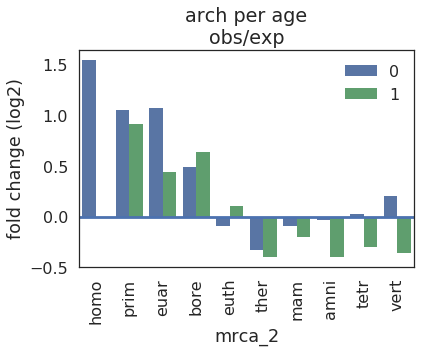

In [43]:
% matplotlib inline
fig, ax = plt.subplots() 
xlabs = ["homo","prim", "euar", "bore", "euth", "ther", "mam", "amni", "tetr", "vert"]
x, y = "mrca_2", "log2_per"
hue = "core_remodeling"
data = ot

sns.barplot(data = data, x = x, y = y, hue = hue, ax = ax)
ax.set(ylabel = "fold change (log2)",
      title = "arch per age\nobs/exp")
ax.set_xticklabels(xlabs, rotation = 90)
plt.axhline(0)
plt.legend(bbox_to_anchor = (1,1))

In [12]:
ot

,core_remodeling,mrca_2,enh_count,enh_percent_arch_per_age,shuf_count,shuf_percent_arch_per_age,per,log2_per
0,0,0.000,62,0.004061,32,0.001385,2.931887,1.551830
1,0,0.126,979,0.064129,713,0.030864,2.077776,1.055040
2,0,0.131,142,0.009302,102,0.004415,2.106656,1.074955
3,0,0.152,829,0.054304,891,0.038570,1.407934,0.493580
4,0,0.175,6380,0.417922,10291,0.445479,0.938142,-0.092122
5,0,0.308,655,0.042906,1241,0.053721,0.798684,-0.324303
6,0,0.380,496,0.032491,799,0.034587,0.939378,-0.090222
7,0,0.490,226,0.014804,348,0.015064,0.982731,-0.025131
8,0,0.656,68,0.004454,101,0.004372,1.018810,0.026885
9,0,0.957,339,0.022206,446,0.019307,1.150192,0.201875


In [25]:
mrcas = ["0.126", "0.131"]
drop_index = list(ot.loc[ot.mrca_2.isin(mrcas)].index)
collapse = ot.loc[ot.mrca_2.isin(mrcas)]
collapse

,core_remodeling,mrca_2,can_count,can_percent_arch,noncan_count,noncan_percent_arch,per,log2_per
1,0,0.126,979,0.064129,713,0.030864,2.077776,1.055040
2,0,0.131,142,0.009302,102,0.004415,2.106656,1.074955
10,1,0.126,242,0.015852,194,0.008398,1.887640,0.916584
11,1,0.131,71,0.004651,79,0.003420,1.359993,0.443600


In [26]:
drop_index

[1, 2, 10, 11]

In [27]:
# drop the euarch and primate mrca
ot = ot.drop(drop_index, axis = 0)

In [29]:
cols = ["can_count", "noncan_count"]
collapse = collapse.groupby("core_remodeling")[cols].sum().reset_index()
collapse["mrca_2"] = 0.131
enh_total = collapse["can_count"].sum()
shuf_total = collapse["noncan_count"].sum()
collapse["can_percent_arch"] = collapse.can_count.divide(enh_total)
collapse["noncan_percent_arch"] = collapse.noncan_count.divide(shuf_total)
collapse["per"] = collapse["can_percent_arch"].divide(collapse["noncan_percent_arch"])
collapse["log2_per"] = np.log2(collapse["per"])

In [30]:
ot = pd.concat([ot, collapse])

In [31]:
ot

,can_count,can_percent_arch,core_remodeling,log2_per,mrca_2,noncan_count,noncan_percent_arch,per
0,62,0.004061,0,1.551830,0.000,32,0.001385,2.931887
3,829,0.054304,0,0.493580,0.152,891,0.038570,1.407934
4,6380,0.417922,0,-0.092122,0.175,10291,0.445479,0.938142
5,655,0.042906,0,-0.324303,0.308,1241,0.053721,0.798684
6,496,0.032491,0,-0.090222,0.380,799,0.034587,0.939378
7,226,0.014804,0,-0.025131,0.490,348,0.015064,0.982731
8,68,0.004454,0,0.026885,0.656,101,0.004372,1.018810
9,339,0.022206,0,0.201875,0.957,446,0.019307,1.150192
12,395,0.025874,1,0.642141,0.152,383,0.016579,1.560644
13,1624,0.106380,1,0.110684,0.175,2276,0.098524,1.079740


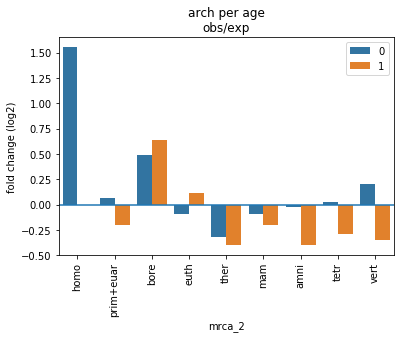

In [32]:
% matplotlib inline
fig, ax = plt.subplots() 
xlabs = ["homo","prim+euar", "bore", "euth", "ther", "mam", "amni", "tetr", "vert"]
x, y = "mrca_2", "log2_per"
hue = "core_remodeling"
data = ot

sns.barplot(data = data, x = x, y = y, hue = hue, ax = ax)
ax.set(ylabel = "fold change (log2)",
      title = "arch per age\nobs/exp")
ax.set_xticklabels(xlabs, rotation = 90)
plt.axhline(0)
plt.legend(bbox_to_anchor = (1,1))

In [62]:
nc = nocancer_fdf.groupby(["core_remodeling"])["enh_id"].count().reset_index()
nc_s = nc.loc[nc.core_remodeling == 0, "enh_id"].iloc[0]
nc_c = nc.loc[nc.core_remodeling != 0, "enh_id"].iloc[0]

c = chen.groupby(["core_remodeling"])["enh_id"].count().reset_index()
c_s = c.loc[c.core_remodeling == 0, "enh_id"].iloc[0]
c_c = c.loc[c.core_remodeling != 0, "enh_id"].iloc[0]

#[[simple_overlapping, simple_nonoverlapping], [complex_overlapping, complex_non-overlapping]]
obs = [[c_s, c_c], [nc_s, nc_c ]]

obs

stats.fisher_exact(obs)

(1.0871161120677839, 0.0001467076922502326)

In [38]:
import numpy as np

In [47]:
mrca_results = {}
for m in nocancer_fdf.mrca_2.unique():
    if m != 0:
        nc = nocancer_fdf.loc[nocancer_fdf["mrca_2"] == m].groupby(["core_remodeling"])["enh_id"].count().reset_index()
        nc_s = nc.loc[nc.core_remodeling == 0, "enh_id"].iloc[0]
        nc_c = nc.loc[nc.core_remodeling != 0, "enh_id"].iloc[0]

        c = chen.loc[chen["mrca_2"] == m].groupby(["core_remodeling"])["enh_id"].count().reset_index()
        c_s = c.loc[c.core_remodeling == 0, "enh_id"].iloc[0]
        c_c = c.loc[c.core_remodeling != 0, "enh_id"].iloc[0]
        obs = [[ c_c, c_s], [ nc_c, nc_s ]]
        print(stats.fisher_exact(obs), m)
        
        OR, P = stats.fisher_exact(obs)
        obs = np.array(obs) # 
        table = sm.stats.Table2x2(obs) # get confidence interval
        odds_ci = table.oddsratio_confint()
        new_df = pd.DataFrame({
            "OR":[OR],
            "P":[P],
            "mrca_2":[m],
            "n_simple_can":[c_s],
            "n_complex_can":[c_c],
            "n_simple_non":[nc_s],
            "n_complex_non":[nc_c],
            "ci_lower" :[odds_ci[0]],
            "ci_upper" :[odds_ci[1]],
            "yerr":[odds_ci[1] - odds_ci[0]], 
            "log2":[np.log2(OR)]
        })
        mrca_results[m] = new_df

(1.1509346540980987, 0.00010973538480160595) 0.175
(0.92885422340575763, 0.30498773682625002) 0.38
(1.1084637504055028, 0.2433643769714729) 0.152
(0.9084906753156492, 0.38519492305663494) 0.126
(0.68137529762630322, 7.7896181627118308e-05) 0.957
(0.95162939407855407, 0.44567289037141378) 0.308
(0.80158730158730163, 0.23743640406415994) 0.656
(0.77199234632862956, 0.015658893675126403) 0.49
(0.64556962025316456, 0.037879376067685613) 0.131


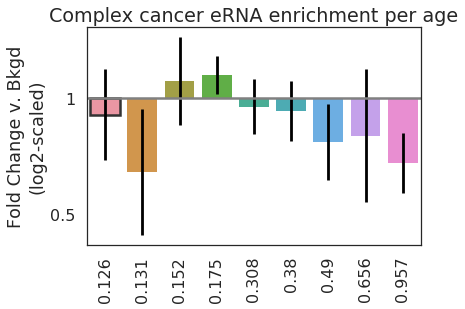

In [48]:
mrca_ = pd.concat(mrca_results.values())
fig, ax = plt.subplots()
sns.set("poster")
sns.set_style("white")

#xlabs = ["euar+prim", "bore", "euth", "ther", "mam", "amni", "tetr", "vert"]
x, y = "mrca_2", "log2"
data = mrca_.sort_values(by = "mrca_2")

sns.barplot(x = x, y = y, data = data,
            linewidth=2.5, 
            edgecolor=".2",
            yerr = data.sort_values(by = "mrca_2")["yerr"])


ax.set(ylabel= "Fold Change v. Bkgd\n(log2-scaled)",
       title = "Complex cancer eRNA enrichment per age", 
       xlabel = "")

#ax.set_xticklabels(xlabs)

plt.axhline(0, color = "grey", linewidth = 2.5)

ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(round(2**x, 1)))

ax.yaxis.set_major_formatter(ticks)
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

plt.savefig("%scomplex_odds_chen_per_mrca_V_FANTOM.pdf" % RE, bbox_inches = 'tight')

plt.show()



(0.86885905853936174, 0.00010973538480160596) 0.175
(1.0765952017027793, 0.30498773682625002) 0.38
(0.90214948358408276, 0.2433643769714729) 0.152
(1.1007267627183475, 0.38519492305663494) 0.126
(1.4676199790096365, 7.7896181627118281e-05) 0.957
(1.0508292474175647, 0.44567289037141378) 0.308
(1.2475247524752475, 0.23743640406415994) 0.656
(1.2953496297673266, 0.015658893675126406) 0.49
(1.5490196078431373, 0.037879376067685606) 0.131


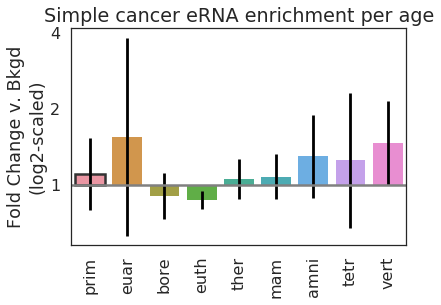

In [61]:
mrca_results = {}
for m in nocancer_fdf.mrca_2.unique():
    if m != 0:
        nc = nocancer_fdf.loc[nocancer_fdf["mrca_2"] == m].groupby(["core_remodeling"])["enh_id"].count().reset_index()
        nc_s = nc.loc[nc.core_remodeling == 0, "enh_id"].iloc[0]
        nc_c = nc.loc[nc.core_remodeling != 0, "enh_id"].iloc[0]

        c = chen.loc[chen["mrca_2"] == m].groupby(["core_remodeling"])["enh_id"].count().reset_index()
        c_s = c.loc[c.core_remodeling == 0, "enh_id"].iloc[0]
        c_c = c.loc[c.core_remodeling != 0, "enh_id"].iloc[0]
        obs = [[ c_s, c_c ], [  nc_s , nc_c]]
        print(stats.fisher_exact(obs), m)
        
        OR, P = stats.fisher_exact(obs)
        obs = np.array(obs) # 
        table = sm.stats.Table2x2(obs) # get confidence interval
        odds_ci = table.oddsratio_confint()
        new_df = pd.DataFrame({
            "OR":[OR],
            "P":[P],
            "mrca_2":[m],
            "n_simple_can":[c_s],
            "n_complex_can":[c_c],
            "n_simple_non":[nc_s],
            "n_complex_non":[nc_c],
            "ci_lower" :[odds_ci[0]],
            "ci_upper" :[odds_ci[1]],
            "yerr":[odds_ci[1] - odds_ci[0]], 
            "log2":[np.log2(OR)]
        })
        mrca_results[m] = new_df
mrca_ = pd.concat(mrca_results.values())
fig, ax = plt.subplots()
sns.set("poster")
sns.set_style("white")

xlabs = ["prim", "euar", "bore", "euth", "ther", "mam", "amni", "tetr", "vert"]
x, y = "mrca_2", "log2"
data = mrca_.sort_values(by = "mrca_2")

sns.barplot(x = x, y = y, data = data,
            linewidth=2.5, 
            edgecolor=".2",
            yerr = data.sort_values(by = "mrca_2")["yerr"])


ax.set(ylabel= "Fold Change v. Bkgd\n(log2-scaled)",
       title = "Simple cancer eRNA enrichment per age", 
       xlabel = "")

ax.set_xticklabels(xlabs)

plt.axhline(0, color = "grey", linewidth = 2.5)

ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(round(2**x, 1)))

ax.yaxis.set_major_formatter(ticks)
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

plt.savefig("%ssimple_odds_chen_per_mrca_V_FANTOM.pdf" % RE, bbox_inches = 'tight')

plt.show()

#### mrca_.sort_values(by = 'mrca_2')

# age only

In [51]:
enh_fold = chen.groupby([ "mrca_2"])["enh_id"].count().reset_index()
enh_fold.columns = ['mrca_2', 'can_count']
#enh_totals = chen.groupby(["mrca_2"])["enh_id"].count().reset_index()
#enh_totals.columns = ['mrca_2', 'enh_total']
#enh_fold = pd.merge(enh_fold, enh_totals)
#enh_fold["enh_percent_arch_per_age"] = enh_fold.enh_count.divide(enh_fold.enh_total)
enh_totals = len(chen)

enh_fold["can_percent_arch"] = enh_fold.can_count.divide(enh_totals)

shuf_fold = nocancer_fdf.groupby([ "mrca_2"])["enh_id"].count().reset_index()
shuf_fold.columns = [ 'mrca_2', 'noncan_count']

#shuf_totals = nocancer_fdf.groupby(["mrca_2"])["enh_id"].count().reset_index()
#shuf_totals.columns = ['mrca_2', 'shuf_total']
#shuf_fold = pd.merge(shuf_fold, shuf_totals)
#shuf_fold["shuf_percent_arch_per_age"] = shuf_fold.shuf_count.divide(shuf_fold.shuf_total)
shuf_totals = len(nocancer_fdf)

shuf_fold["noncan_percent_arch"] = shuf_fold.noncan_count.divide(shuf_totals)

ot = pd.merge(enh_fold, shuf_fold)
ot["per"] = ot.can_percent_arch.divide(ot.noncan_percent_arch)
ot["log2_per"] = np.log2(ot["per"])

ot[[ "mrca_2","per", "log2_per"]].sort_values(by = [ "mrca_2",])

,mrca_2,per,log2_per
0,0.000,2.931887,1.551830
1,0.126,2.037107,1.026522
2,0.131,1.780765,0.832497
3,0.152,1.453843,0.539871
4,0.175,0.963787,-0.053214
5,0.308,0.776016,-0.365841
6,0.380,0.894814,-0.160341
7,0.490,0.830330,-0.268243
8,0.656,0.859288,-0.218786
9,0.957,0.923175,-0.115324


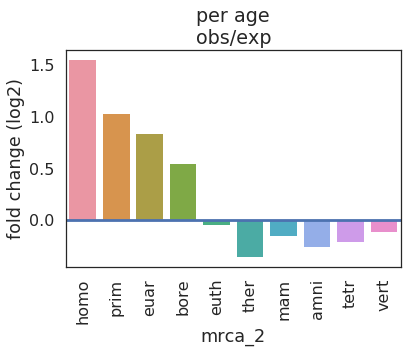

In [53]:
% matplotlib inline
fig, ax = plt.subplots() 
xlabs = ["homo","prim", "euar", "bore", "euth", "ther", "mam", "amni", "tetr", "vert"]
x, y = "mrca_2", "log2_per"

data = ot

sns.barplot(data = data, x = x, y = y,  ax = ax)
ax.set(ylabel = "fold change (log2)",
      title = "per age\nobs/exp")
ax.set_xticklabels(xlabs, rotation = 90)
plt.axhline(0)
plt.legend(bbox_to_anchor = (1,1))